# Анализ тарифов федерального оператора сотовой связи.
Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. Данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

**Цель:** Проанализировать и сделать вывод — какой тариф лучше.


## Данные для анализа:

**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана


**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from scipy import stats as st

import plotly.io as pio
pio.renderers.default = 'svg'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
try:
    df_calls = pd.read_csv('secret.csv', parse_dates=['call_date'])
    df_internet = pd.read_csv('secret.csv')
    df_messages = pd.read_csv('secret.csv')
    df_tariffs = pd.read_csv('secret.csv')
    df_users = pd.read_csv('secret.csv', parse_dates=['reg_date'])
except Exception as err:
    print('Ошибка:', err)

In [3]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные прочитаны, ошибок нет, приступим к преодобработке.

## Предобработка данных

Напишем функцию, которая будет возвращать нам первичную информацию о датафрейме.

In [8]:
def primary_info(df):
    display(df.head())
    print()
    print('Проверка на пропущенные значения:')
    display(pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    print('----------------')
    print()
    print('Проверка типа данных на корректность:')
    print(df.info())
    print('----------------')
    print()
    print('Количество дубликатов:', df.duplicated().sum())

Приступим к предобработке.

### Пользователи

In [9]:
primary_info(df_users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



Проверка на пропущенные значения:


,0
user_id,0.000000
age,0.000000
churn_date,92.400000
city,0.000000
first_name,0.000000
last_name,0.000000
reg_date,0.000000
tariff,0.000000


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB
None
----------------

Количество дубликатов: 0


* Видим 2 проблемы: 92% пропусков и неверный тип данных у столбцов с датой (reg_date, churn_date). 

* Что касается пропусков - в описании проекта сказано: если значение 'churn_date' пропущено, то тариф ещё действовал на момент выгрузки данных, значит с этим все в порядке, оставим пропуски для понимания, какие абоненты еще с нами.

* Исправим тип данных.


In [10]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')

### Звонки

In [11]:
primary_info(df_calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



Проверка на пропущенные значения:


,0
id,0.000000
call_date,0.000000
duration,0.000000
user_id,0.000000


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None
----------------

Количество дубликатов: 0


В столбце 'duration' есть значения - 0. Это пропущенные звонки, посмотрим их долю в общем количестве.

In [12]:
len(df_calls.query('duration == 0')) / len(df_calls)

0.19551644316336553

20% от всей совокупности - довольно много, обрабатывать их, я считаю, не нужно.

Пропусков нет, есть аналогичная проблема с типом данных.

In [13]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')

### Интернет

In [14]:
primary_info(df_internet)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



Проверка на пропущенные значения:


,0
Unnamed: 0,0.000000
id,0.000000
mb_used,0.000000
session_date,0.000000
user_id,0.000000


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
----------------

Количество дубликатов: 0


Есть проблема с датой и появился лишний столбец, дублирующий индекс, удалим его.

In [15]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')

In [16]:
df_internet.drop('Unnamed: 0', axis=1, inplace=True)

### Сообщения

In [17]:
primary_info(df_messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



Проверка на пропущенные значения:


,0
id,0.000000
message_date,0.000000
user_id,0.000000


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
----------------

Количество дубликатов: 0


Снова проблема с датой.

In [18]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')

### Тарифы

In [19]:
primary_info(df_tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



Проверка на пропущенные значения:


,0
messages_included,0.000000
mb_per_month_included,0.000000
minutes_included,0.000000
rub_monthly_fee,0.000000
rub_per_gb,0.000000
rub_per_message,0.000000
rub_per_minute,0.000000
tariff_name,0.000000


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
----------------

Количество дубликатов: 0


Здесь исправим тип данных у столбца с названием тарифа на category, т.к. там есть всего 2 возможных варианта - smart и ultra. Это позволит нам сэкономить немного памяти

In [20]:
df_tariffs['tariff_name'] = df_tariffs['tariff_name'].astype('category')

Проверим наличие дубликатов сразу во всех фреймах.

* Также в описании проекта указано - «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. 

* Округлим значения в бОльшую сторону и приведем к типу данных int

In [21]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype('int')
df_internet['mb_used'] = np.ceil(df_internet['mb_used']).astype('int')

### Вывод

* С пропусками проблем не было
* Был заменен тип данных в столбцах с датой и с использованием минут/интернета с округлением в бОльшую сторону
* Был удален лишний столбец
* Так же проверил датасет на наличие дубликатов - их нет.

## Расчеты

### Количество сделанных звонков и израсходованных минут разговора по месяцам


Считаем количество сделанных звонков.

In [22]:
calls_per_month = df_calls.pivot_table(
    index='user_id',
    columns=df_calls['call_date'].dt.month,
    values='id',
    aggfunc='count')

calls_per_month

call_date,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0
1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0
1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,112.0,152.0,129.0,155.0
1496,7.0,77.0,79.0,67.0,63.0,74.0,73.0,88.0,68.0,72.0,80.0,80.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,64.0,71.0


Считаем количество израсходованных минут.

In [23]:
calls_duration_per_month = df_calls.pivot_table(index='user_id', columns=df_calls['call_date'].dt.month, values='duration', aggfunc='sum')
calls_duration_per_month

call_date,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0
1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0


### Количество отправленных сообщений по месяцам

In [24]:
messages_per_month = df_messages.pivot_table(index='user_id', columns=df_messages['message_date'].dt.month, values='id', aggfunc='count')
messages_per_month

message_date,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0


### Объем израсходованного интернет-трафика по месяцам

In [25]:
mb_per_month = df_internet.pivot_table(index='user_id', columns=df_internet['session_date'].dt.month, values='mb_used', aggfunc='sum')
mb_per_month

session_date,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18452.0,14053.0
1002,NaN,NaN,NaN,NaN,NaN,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571.0,12479.0,14779.0,11368.0,10132.0
1004,NaN,NaN,NaN,NaN,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2616.0,33105.0,29393.0,38972.0,23450.0
1496,3766.0,28523.0,24990.0,21098.0,23740.0,20163.0,24395.0,23560.0,26970.0,28215.0,25092.0,20757.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11512.0,14174.0,19940.0


### Помесячная выручка с каждого пользователя

Как считаем: 
1. Вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика
2. Остаток умножаем на значение из тарифного плана
3. Прибавляем абонентскую плату по тарифу

#### Количество звонков

In [26]:
dr = pd.DataFrame(df_users.groupby('user_id')['tariff'].min())
dr.columns = ['tariff_name']
dr

,tariff_name
user_id,
1000,ultra
1001,smart
1002,smart
1003,ultra
1004,ultra
...,...
1495,ultra
1496,smart
1497,smart


In [27]:
dr_call = dr.join(pd.DataFrame(df_tariffs.groupby('tariff_name')[['minutes_included', 'rub_per_minute']].min()), on='tariff_name')
dr_call

,tariff_name,minutes_included,rub_per_minute
user_id,,,
1000,ultra,3000,1
1001,smart,500,3
1002,smart,500,3
1003,ultra,3000,1
1004,ultra,3000,1
...,...,...,...
1495,ultra,3000,1
1496,smart,500,3
1497,smart,500,3


In [28]:
calls_duration_balance_per_month = calls_duration_per_month.join(dr_call, on='user_id')
calls_duration_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,minutes_included,rub_per_minute
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,ultra,3000,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,smart,500,3
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,smart,500,3
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,ultra,3000,1
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,ultra,3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0,ultra,3000,1
1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0,smart,500,3
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0,smart,500,3


Создам list с месяцами для последующих расчетов.

In [29]:
list = [1,2,3,4,5,6,7,8,9,10,11,12]

In [30]:
def find_call_balance(x):
  return x - calls_duration_balance_per_month['minutes_included']

calls_duration_balance_per_month = calls_duration_balance_per_month.loc[:, list].apply(find_call_balance)
calls_duration_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,-2841.0,-2828.0,-2660.0,-2592.0,-2534.0,-2650.0,-2662.0,-2667.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.0,-86.0
1002,NaN,NaN,NaN,NaN,NaN,-383.0,-286.0,-211.0,-294.0,-288.0,-257.0,-264.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2620.0,-2039.0,-2145.0,-2176.0,-2198.0
1004,NaN,NaN,NaN,NaN,-2965.0,-2829.0,-2865.0,-2863.0,-2883.0,-2855.0,-2883.0,-2870.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2908.0,-2187.0,-1970.0,-2046.0,-1969.0
1496,-452.0,94.0,57.0,21.0,-16.0,55.0,82.0,27.0,-14.0,-50.0,162.0,18.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.0,-129.0,45.0


У нас отвалились два последних столбца, надо обратно их замерджить.

In [31]:
calls_duration_balance_per_month = calls_duration_balance_per_month.join(dr_call, on='user_id')
calls_duration_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,minutes_included,rub_per_minute
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,-2841.0,-2828.0,-2660.0,-2592.0,-2534.0,-2650.0,-2662.0,-2667.0,ultra,3000,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.0,-86.0,smart,500,3
1002,NaN,NaN,NaN,NaN,NaN,-383.0,-286.0,-211.0,-294.0,-288.0,-257.0,-264.0,smart,500,3
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2620.0,-2039.0,-2145.0,-2176.0,-2198.0,ultra,3000,1
1004,NaN,NaN,NaN,NaN,-2965.0,-2829.0,-2865.0,-2863.0,-2883.0,-2855.0,-2883.0,-2870.0,ultra,3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2908.0,-2187.0,-1970.0,-2046.0,-1969.0,ultra,3000,1
1496,-452.0,94.0,57.0,21.0,-16.0,55.0,82.0,27.0,-14.0,-50.0,162.0,18.0,smart,500,3
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.0,-129.0,45.0,smart,500,3


Минусовые значения означают, что наш пользователь не израсходовал бесплатные минуты, а всё, что больше 0 - количество минут сверх пакета. 

Заполним минусовые значения нулем.

In [32]:
num = calls_duration_balance_per_month._get_numeric_data()
num[num < 0] = 0

calls_duration_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,minutes_included,rub_per_minute
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000,1
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,smart,500,3
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,500,3
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,3000,1
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,3000,1
1496,0.0,94.0,57.0,21.0,0.0,55.0,82.0,27.0,0.0,0.0,162.0,18.0,smart,500,3
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,45.0,smart,500,3


У нас получился датафрейм, где по месяцам указано, сколько каждый пользователь использовал минут сверх тарифа. Чтобы подсчитать, сколько он принес выручки, нужно будет просто умножить значения на стоимость по тарифу. 

Нулевые значения останутся 0, потому что пользователь либо не звонил в этом месяце, либо звонил, но не вышел за пределы установленного лимита.

In [33]:
def call_revenue(x):
  return x * calls_duration_balance_per_month['rub_per_minute']
  
calls_duration_balance_per_month = calls_duration_balance_per_month.loc[:, list].apply(call_revenue)
calls_duration_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1496,0.0,282.0,171.0,63.0,0.0,165.0,246.0,81.0,0.0,0.0,486.0,54.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,135.0


#### Количество сообщений 

In [34]:
dr_message = dr.join(pd.DataFrame(df_tariffs.groupby('tariff_name')[['messages_included', 'rub_per_message']].min()), on='tariff_name')
dr_message

,tariff_name,messages_included,rub_per_message
user_id,,,
1000,ultra,1000,1
1001,smart,50,3
1002,smart,50,3
1003,ultra,1000,1
1004,ultra,1000,1
...,...,...,...
1495,ultra,1000,1
1496,smart,50,3
1497,smart,50,3


In [35]:
messages_balance_per_month = messages_per_month.join(dr_message, on='user_id')
messages_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,messages_included,rub_per_message
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra,1000,1
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart,50,3
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0,ultra,1000,1
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra,1000,1
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart,50,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0,ultra,1000,1
1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0,smart,50,3
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0,smart,50,3


In [36]:
def find_messages_balance(x):
  return x - messages_balance_per_month['messages_included']

messages_balance_per_month = messages_balance_per_month.loc[:, list].apply(find_messages_balance)
messages_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,-978.0,-940.0,-925.0,-919.0,-943.0,-927.0,-942.0,-930.0
1002,NaN,NaN,NaN,NaN,NaN,-46.0,-39.0,-37.0,-46.0,-40.0,-34.0,-38.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-963.0,-909.0,-917.0,-906.0,-925.0
1004,NaN,NaN,NaN,NaN,-905.0,-866.0,-819.0,-849.0,-854.0,-835.0,-842.0,-838.0
1005,-43.0,-12.0,6.0,-9.0,-8.0,-3.0,6.0,14.0,2.0,-6.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-987.0,-918.0,-918.0,-921.0,-916.0
1496,-41.0,-5.0,-4.0,-1.0,-10.0,-15.0,-8.0,-9.0,-21.0,-15.0,-4.0,1.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-30.0,-36.0,-33.0


In [37]:
messages_balance_per_month = messages_balance_per_month.join(dr_message, on='user_id')
messages_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,messages_included,rub_per_message
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,-978.0,-940.0,-925.0,-919.0,-943.0,-927.0,-942.0,-930.0,ultra,1000,1
1002,NaN,NaN,NaN,NaN,NaN,-46.0,-39.0,-37.0,-46.0,-40.0,-34.0,-38.0,smart,50,3
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-963.0,-909.0,-917.0,-906.0,-925.0,ultra,1000,1
1004,NaN,NaN,NaN,NaN,-905.0,-866.0,-819.0,-849.0,-854.0,-835.0,-842.0,-838.0,ultra,1000,1
1005,-43.0,-12.0,6.0,-9.0,-8.0,-3.0,6.0,14.0,2.0,-6.0,1.0,4.0,smart,50,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-987.0,-918.0,-918.0,-921.0,-916.0,ultra,1000,1
1496,-41.0,-5.0,-4.0,-1.0,-10.0,-15.0,-8.0,-9.0,-21.0,-15.0,-4.0,1.0,smart,50,3
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-30.0,-36.0,-33.0,smart,50,3


И делаем тоже самое, что и для звонков.

In [38]:
num = messages_balance_per_month._get_numeric_data()
num[num < 0] = 0

messages_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,messages_included,rub_per_message
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000,1
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart,50,3
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,1000,1
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000,1
1005,0.0,0.0,6.0,0.0,0.0,0.0,6.0,14.0,2.0,0.0,1.0,4.0,smart,50,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,1000,1
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,smart,50,3
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,smart,50,3


In [39]:
def message_revenue(x):
  return x * messages_balance_per_month['rub_per_message']
  
messages_balance_per_month = messages_balance_per_month.loc[:, list].apply(message_revenue)
messages_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


#### Интернет-трафик

In [40]:
dr_internet = dr.join(pd.DataFrame(df_tariffs.groupby('tariff_name')[['mb_per_month_included', 'rub_per_gb']].min()), on='tariff_name')
dr_internet

,tariff_name,mb_per_month_included,rub_per_gb
user_id,,,
1000,ultra,30720,150
1001,smart,15360,200
1002,smart,15360,200
1003,ultra,30720,150
1004,ultra,30720,150
...,...,...,...
1495,ultra,30720,150
1496,smart,15360,200
1497,smart,15360,200


In [41]:
mb_balance_per_month = mb_per_month.join(dr_internet, on='user_id')
mb_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,mb_per_month_included,rub_per_gb
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0,ultra,30720,150
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18452.0,14053.0,smart,15360,200
1002,NaN,NaN,NaN,NaN,NaN,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0,smart,15360,200
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571.0,12479.0,14779.0,11368.0,10132.0,ultra,30720,150
1004,NaN,NaN,NaN,NaN,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0,ultra,30720,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2616.0,33105.0,29393.0,38972.0,23450.0,ultra,30720,150
1496,3766.0,28523.0,24990.0,21098.0,23740.0,20163.0,24395.0,23560.0,26970.0,28215.0,25092.0,20757.0,smart,15360,200
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11512.0,14174.0,19940.0,smart,15360,200


In [42]:
def find_internet_balance(x):
  return x - mb_balance_per_month['mb_per_month_included']

mb_balance_per_month = mb_balance_per_month.loc[:, list].apply(find_internet_balance)
mb_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,-28464.0,-7463.0,-16704.0,-16650.0,-16139.0,-16003.0,-15952.0,-20893.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3092.0,-1307.0
1002,NaN,NaN,NaN,NaN,NaN,-4489.0,2241.0,4987.0,1352.0,-1455.0,3250.0,2777.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22149.0,-18241.0,-15941.0,-19352.0,-20588.0
1004,NaN,NaN,NaN,NaN,-17305.0,-13101.0,-8477.0,-2113.0,-15595.0,-12226.0,-15089.0,-12682.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28104.0,2385.0,-1327.0,8252.0,-7270.0
1496,-11594.0,13163.0,9630.0,5738.0,8380.0,4803.0,9035.0,8200.0,11610.0,12855.0,9732.0,5397.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3848.0,-1186.0,4580.0


In [43]:
mb_balance_per_month = mb_balance_per_month.join(dr_internet, on='user_id')
mb_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,mb_per_month_included,rub_per_gb
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,-28464.0,-7463.0,-16704.0,-16650.0,-16139.0,-16003.0,-15952.0,-20893.0,ultra,30720,150
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3092.0,-1307.0,smart,15360,200
1002,NaN,NaN,NaN,NaN,NaN,-4489.0,2241.0,4987.0,1352.0,-1455.0,3250.0,2777.0,smart,15360,200
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22149.0,-18241.0,-15941.0,-19352.0,-20588.0,ultra,30720,150
1004,NaN,NaN,NaN,NaN,-17305.0,-13101.0,-8477.0,-2113.0,-15595.0,-12226.0,-15089.0,-12682.0,ultra,30720,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-28104.0,2385.0,-1327.0,8252.0,-7270.0,ultra,30720,150
1496,-11594.0,13163.0,9630.0,5738.0,8380.0,4803.0,9035.0,8200.0,11610.0,12855.0,9732.0,5397.0,smart,15360,200
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3848.0,-1186.0,4580.0,smart,15360,200


In [44]:
num = mb_balance_per_month._get_numeric_data()
num[num < 0] = 0

mb_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,mb_per_month_included,rub_per_gb
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,30720,150
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3092.0,0.0,smart,15360,200
1002,NaN,NaN,NaN,NaN,NaN,0.0,2241.0,4987.0,1352.0,0.0,3250.0,2777.0,smart,15360,200
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,ultra,30720,150
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,30720,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2385.0,0.0,8252.0,0.0,ultra,30720,150
1496,0.0,13163.0,9630.0,5738.0,8380.0,4803.0,9035.0,8200.0,11610.0,12855.0,9732.0,5397.0,smart,15360,200
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4580.0,smart,15360,200


Считаем выручку за интернет сверх лимита. 

Стоимость у нас указана за ГБ, то есть надо поделить мб на 1024, округлить в бОльшую сторону и умножить на стоимость 1 гб.

In [45]:
def internet_revenue(x):
  return np.ceil(x/1024) * mb_balance_per_month['rub_per_gb']
  
mb_balance_per_month = mb_balance_per_month.loc[:, list].apply(internet_revenue)
mb_balance_per_month

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,450.0,0.0,1350.0,0.0
1496,0.0,2600.0,2000.0,1200.0,1800.0,1000.0,1800.0,1800.0,2400.0,2600.0,2000.0,1200.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1000.0


#### Выручка

Теперь соединим все датафреймы для окончательного расчета.

In [46]:
revenue_calls = dr.merge(calls_duration_balance_per_month, on='user_id', how='outer')
revenue_calls

,tariff_name,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,,
1000,ultra,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1002,smart,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,ultra,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1496,smart,0.0,282.0,171.0,63.0,0.0,165.0,246.0,81.0,0.0,0.0,486.0,54.0
1497,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,135.0


In [47]:
revenue_messages = dr.merge(messages_balance_per_month, on='user_id', how='outer')
revenue_messages

,tariff_name,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,,
1000,ultra,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,smart,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,ultra,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1496,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1497,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [48]:
revenue_internet = dr.merge(mb_balance_per_month, on='user_id', how='outer')
revenue_internet

,tariff_name,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,,
1000,ultra,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.0,0.0
1002,smart,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0
1003,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,ultra,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,ultra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,450.0,0.0,1350.0,0.0
1496,smart,0.0,2600.0,2000.0,1200.0,1800.0,1000.0,1800.0,1800.0,2400.0,2600.0,2000.0,1200.0
1497,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1000.0


In [49]:
revenue = revenue_calls + revenue_messages + revenue_internet
revenue.drop('tariff_name', axis=1, inplace=True)
revenue

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,450.0,0.0,1350.0,0.0
1496,0.0,2882.0,2171.0,1263.0,1800.0,1165.0,2046.0,1881.0,2400.0,2600.0,2486.0,1257.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1135.0


### Вывод
* NaN - пользователь еще не был нашим абонентом.
* 0 - пользователь был нашим абонентом, но не израсходовал бесплатный лимит.
* Остальные числа - сколько нам заплатил пользователь без учета абонентской платы.

Для окончательной суммы прибавим абонентскую плату.

In [50]:
rub_monthle_fee = dr.join(pd.DataFrame(df_tariffs.groupby('tariff_name')['rub_monthly_fee'].min()), on='tariff_name')
rub_monthle_fee

,tariff_name,rub_monthly_fee
user_id,,
1000,ultra,1950
1001,smart,550
1002,smart,550
1003,ultra,1950
1004,ultra,1950
...,...,...
1495,ultra,1950
1496,smart,550
1497,smart,550


In [51]:
revenue = revenue.join(rub_monthle_fee, on='user_id')

In [52]:
def revenue_(x):
  return x + revenue['rub_monthly_fee']

revenue = revenue.loc[:, list].apply(revenue_)
revenue

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0
1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,2400.0,1950.0,3300.0,1950.0
1496,550.0,3432.0,2721.0,1813.0,2350.0,1715.0,2596.0,2431.0,2950.0,3150.0,3036.0,1807.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,550.0,1685.0


In [53]:
revenue.loc[:,'total'] = revenue.sum(axis=1)
revenue

,1,2,3,4,5,6,7,8,9,10,11,12,total
user_id,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1002,NaN,NaN,NaN,NaN,NaN,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0,7250.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,9750.0
1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,2400.0,1950.0,3300.0,1950.0,11550.0
1496,550.0,3432.0,2721.0,1813.0,2350.0,1715.0,2596.0,2431.0,2950.0,3150.0,3036.0,1807.0,28551.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,550.0,1685.0,2785.0


## Анализ данных

### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

### Длительность звонков

#### Среднее значение

In [54]:
calls_smart = df_calls.join(dr, on='user_id')
calls_smart = calls_smart.query('tariff_name == "smart"')
calls_smart

,id,call_date,duration,user_id,tariff_name
368,1001_0,2018-11-13,11,1001,smart
369,1001_1,2018-12-14,16,1001,smart
370,1001_2,2018-11-20,3,1001,smart
371,1001_3,2018-12-27,8,1001,smart
372,1001_4,2018-11-19,20,1001,smart
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,smart
202603,1499_216,2018-10-18,19,1499,smart
202604,1499_217,2018-11-10,11,1499,smart
202605,1499_218,2018-10-06,5,1499,smart


In [55]:
calls_ultra = df_calls.join(dr, on='user_id')
calls_ultra = calls_ultra.query('tariff_name == "ultra"')
calls_ultra

,id,call_date,duration,user_id,tariff_name
0,1000_0,2018-07-25,0,1000,ultra
1,1000_1,2018-08-17,0,1000,ultra
2,1000_2,2018-06-11,3,1000,ultra
3,1000_3,2018-09-21,14,1000,ultra
4,1000_4,2018-12-15,6,1000,ultra
...,...,...,...,...,...
201173,1495_560,2018-09-24,13,1495,ultra
201174,1495_561,2018-12-05,10,1495,ultra
201175,1495_562,2018-10-05,1,1495,ultra
201176,1495_563,2018-09-18,1,1495,ultra


У нас много пропущенных звонков - 0 минут, поэтому будем анализировать данные с ними и без них.

In [56]:
calls_smart_duration_mean = calls_smart['duration'].mean()
calls_smart_duration_non_null_mean = calls_smart.query('duration > 0')['duration'].mean()
print('Средняя длительность звонков: {:.2f}'.format(calls_smart_duration_mean))
print('Средняя длительность звонков без учета пропущенных: {:.2f}'.format(calls_smart_duration_non_null_mean))
print('Доля пропущенных звонков: {:.1%}'.format(len(calls_smart.query('duration == 0')) / len(calls_smart)))

Средняя длительность звонков: 7.15
Средняя длительность звонков без учета пропущенных: 8.90
Доля пропущенных звонков: 19.7%


In [57]:
calls_ultra_duration_mean = calls_ultra['duration'].mean()
calls_ultra_duration_non_null_mean = calls_ultra.query('duration > 0')['duration'].mean()
print('Средняя длительность звонков: {:.2f}'.format(calls_ultra_duration_mean))
print('Средняя длительность звонков без учета пропущенных: {:.2f}'.format(calls_ultra_duration_non_null_mean))
print('Доля пропущенных звонков: {:.1%}'.format(len(calls_ultra.query('duration == 0')) / len(calls_ultra)))

Средняя длительность звонков: 7.18
Средняя длительность звонков без учета пропущенных: 8.89
Доля пропущенных звонков: 19.3%


#### Дисперсия и стандартное отклонение

**Smart-тариф**

Мы анализируем по выборке, поэтому для стандартного отклонения используем параметр ddof = 1

In [58]:
print('Дисперсия равна {:.2f}'.format(calls_smart['duration'].var()))
print('Стандартное отклонение равно {:.2f}'.format(np.std(calls_smart['duration'], ddof=1)))
print('-------------------------------------------------------------------------------')
print('Без учета пропущенных звонков дисперсия равна {:.2f}'.format(calls_smart.query('duration > 0')['duration'].var()))
print('Без учета пропущенных звонков стандартное отклонение равно {:.2f}'.format(np.std(calls_smart.query('duration > 0')['duration'], ddof=1)))

Дисперсия равна 35.51
Стандартное отклонение равно 5.96
-------------------------------------------------------------------------------
Без учета пропущенных звонков дисперсия равна 28.61
Без учета пропущенных звонков стандартное отклонение равно 5.35


**Ultra-тариф**

In [59]:
print('Дисперсия равна {:.2f}'.format(calls_ultra['duration'].var()))
print('Стандартное отклонение равно {:.2f}'.format(np.std(calls_ultra['duration'], ddof=1)))
print('-------------------------------------------------------------------------------')
print('Без учета пропущенных звонков дисперсия равна {:.2f}'.format(calls_ultra.query('duration > 0')['duration'].var()))
print('Без учета пропущенных звонков стандартное отклонение равно {:.2f}'.format(np.std(calls_ultra.query('duration > 0')['duration'], ddof=1)))

Дисперсия равна 35.52
Стандартное отклонение равно 5.96
-------------------------------------------------------------------------------
Без учета пропущенных звонков дисперсия равна 28.76
Без учета пропущенных звонков стандартное отклонение равно 5.36


#### Гистограмма

**Smart-тариф**

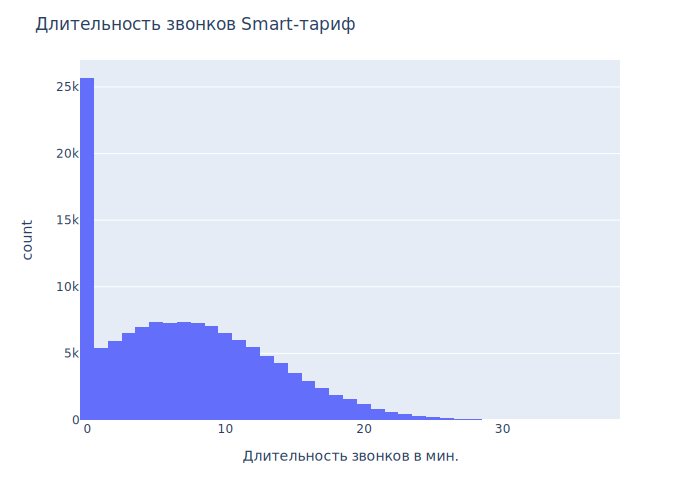

In [60]:
fig = px.histogram(calls_smart, x='duration')
fig.update_layout(title='Длительность звонков Smart-тариф',
                  xaxis_title='Длительность звонков в мин.')
fig.show()

**Ultra-тариф**

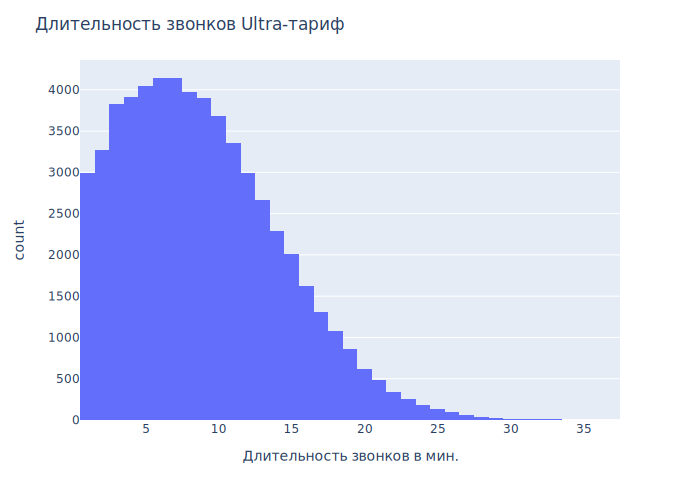

In [61]:
fig = px.histogram(calls_ultra.query('duration != 0'), x='duration')
fig.update_layout(title='Длительность звонков Ultra-тариф',
                  xaxis_title='Длительность звонков в мин.')
fig.show()

#### Вывод

* В среднем пользователи разговаривают 7 минут
* Пользователей в тарифе смарт хоть и больше, но распределения у тарифов почти идентичны.
* Распределение Пуассона

### Количество сообщений

#### Среднее значение

**Smart-тариф**

In [62]:
messages_smart = df_messages.join(dr, on='user_id')
messages_smart = messages_smart.query('tariff_name == "smart"')
messages_smart

,id,message_date,user_id,tariff_name
496,1002_0,2018-11-24,1002,smart
497,1002_1,2018-10-26,1002,smart
498,1002_2,2018-10-13,1002,smart
499,1002_3,2018-12-09,1002,smart
500,1002_4,2018-11-12,1002,smart
...,...,...,...,...
123031,1499_179,2018-12-12,1499,smart
123032,1499_180,2018-09-28,1499,smart
123033,1499_181,2018-09-27,1499,smart
123034,1499_182,2018-11-15,1499,smart


In [63]:
mess_smart = pd.DataFrame(messages_smart.groupby('user_id')['id'].agg('count'))
mess_smart.columns = ['count_messages']
mess_smart

,count_messages
user_id,
1002,70
1005,552
1007,225
1008,56
1009,110
...,...
1492,98
1496,468
1497,51


In [64]:
print('Среднее количество сообщений: {:.0f}'.format(np.ceil(mess_smart['count_messages'].mean())))

Среднее количество сообщений: 247


**Ultra-тариф**

In [65]:
messages_ultra = df_messages.join(dr, on='user_id')
messages_ultra = messages_ultra.query('tariff_name == "ultra"')
messages_ultra

,id,message_date,user_id,tariff_name
0,1000_0,2018-06-27,1000,ultra
1,1000_1,2018-10-08,1000,ultra
2,1000_2,2018-08-04,1000,ultra
3,1000_3,2018-06-16,1000,ultra
4,1000_4,2018-12-05,1000,ultra
...,...,...,...,...
122160,1495_335,2018-09-20,1495,ultra
122161,1495_336,2018-10-28,1495,ultra
122162,1495_337,2018-12-14,1495,ultra
122163,1495_338,2018-09-02,1495,ultra


In [66]:
mess_ultra = pd.DataFrame(messages_ultra.groupby('user_id')['id'].agg('count'))
mess_ultra.columns = ['count_messages']
mess_ultra

,count_messages
user_id,
1000,496
1003,380
1004,1192
1013,42
1016,142
...,...
1476,45
1485,155
1491,432


In [67]:
print('Среднее количество сообщений: {:.0f}'.format(np.ceil(mess_ultra['count_messages'].mean())))

Среднее количество сообщений: 393


#### Дисперсия и стандартное отклонение

In [68]:
print('    Smart-тариф    ')
print('Дисперсия равна {:.2f}'.format(mess_smart['count_messages'].var()))
print('Стандартное отклонение равно {:.2f}'.format(np.std(mess_smart['count_messages'], ddof=1)))
print('-------------------------------')
print('    Ultra-тариф    ')
print('Дисперсия равна {:.2f}'.format(mess_ultra['count_messages'].var()))
print('Стандартное отклонение равно {:.2f}'.format(np.std(mess_ultra['count_messages'], ddof=1)))

    Smart-тариф    
Дисперсия равна 49455.23
Стандартное отклонение равно 222.39
-------------------------------
    Ultra-тариф    
Дисперсия равна 111245.59
Стандартное отклонение равно 333.53


#### Гистограмма

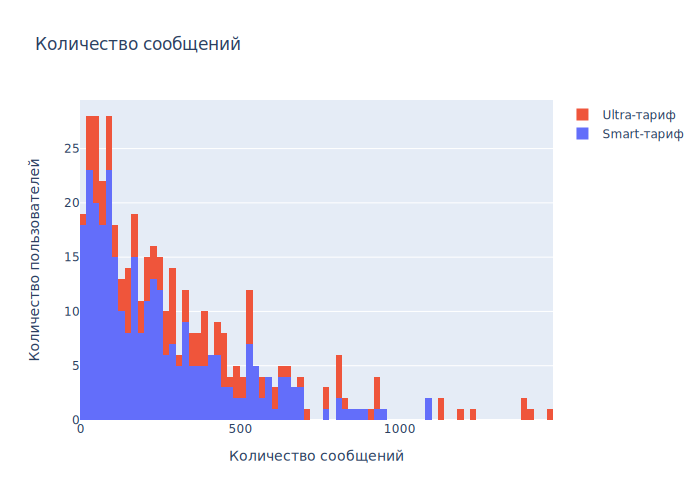

In [69]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=mess_smart['count_messages'], name='Smart-тариф', nbinsx=100))
fig.add_trace(go.Histogram(x=mess_ultra['count_messages'], name='Ultra-тариф', nbinsx=100))

fig.update_layout(title='Количество сообщений',
                  xaxis_title='Количество сообщений',
                  yaxis_title='Количество пользователей',
                  barmode='stack')
fig.show()

### Интернет-трафик

**Smart-тариф**

In [70]:
internet_smart = pd.DataFrame(df_internet.join(dr, on='user_id').query('tariff_name == "smart"').groupby('user_id')['mb_used'].agg('sum'))
internet_smart

,mb_used
user_id,
1001,32505
1002,116183
1005,99813
1006,164395
1007,131792
...,...
1494,77102
1496,271269
1497,45626


In [71]:
print('Средний объем интернет-трафика: {:.2f}'.format(internet_smart['mb_used'].mean()))
print('Дисперсия равна: {:.2f}'.format(internet_smart['mb_used'].var()))
print('Стандартное отклонение равно: {:.2f}'.format(np.std(internet_smart['mb_used'], ddof=1)))

Средний объем интернет-трафика: 103356.75
Дисперсия равна: 3632381866.56
Стандартное отклонение равно: 60269.24


**Ultra-тариф**

In [72]:
internet_ultra = pd.DataFrame(df_internet.join(dr, on='user_id').query('tariff_name == "ultra"').groupby('user_id')['mb_used'].agg('sum'))
internet_ultra

,mb_used
user_id,
1000,107492
1003,57329
1004,149172
1013,30545
1016,26834
...,...
1476,150429
1485,23447
1491,161612


In [73]:
print('Средний объем интернет-трафика: {:.2f}'.format(internet_ultra['mb_used'].mean()))
print('Дисперсия равна: {:.2f}'.format(internet_ultra['mb_used'].var()))
print('Стандартное отклонение равно: {:.2f}'.format(np.std(internet_ultra['mb_used'], ddof=1)))

Средний объем интернет-трафика: 130575.50
Дисперсия равна: 7650529580.18
Стандартное отклонение равно: 87467.31


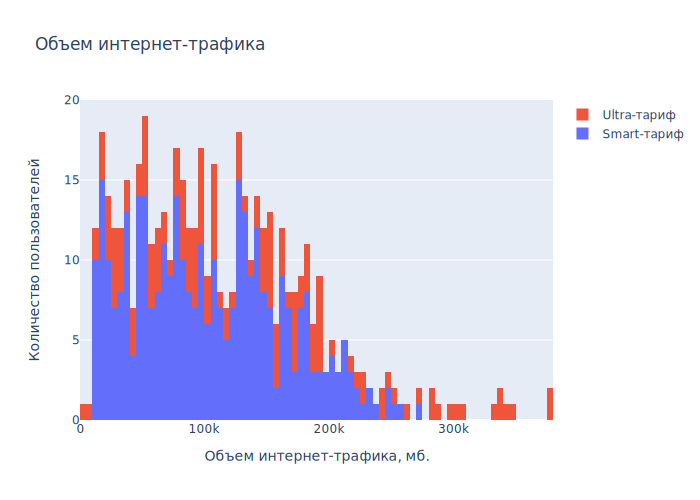

In [74]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=internet_smart['mb_used'], name='Smart-тариф', nbinsx=100))
fig.add_trace(go.Histogram(x=internet_ultra['mb_used'], name='Ultra-тариф', nbinsx=100))

fig.update_layout(title='Объем интернет-трафика',
                  xaxis_title='Объем интернет-трафика, мб.',
                  yaxis_title='Количество пользователей',
                  barmode='stack')
fig.show()

### Вывод

Для наглядности выведем всё, что сейчас считали, в одной ячейке

In [75]:
revenue = revenue.join(dr, on='user_id')

In [76]:
print('Смарт-тариф, в среднем за месяц:')
print('')
print('Длительность звонков: {:.2f}'.format(calls_smart_duration_mean))
print('Длительность звонков без учета пропущенных: {:.2f}'.format(calls_smart_duration_non_null_mean))
print('Сообщений: {:.0f}'.format(np.ceil(mess_smart['count_messages'].mean())))
print('Объем интернет-трафика: {:.2f}'.format(internet_smart['mb_used'].mean()))
print('')
print('Стандартное отклонение длительности звонков: {:.2f}'.format(np.std(calls_smart['duration'], ddof=1)))
print('Стандартное отклонение длительности звонков без учета пропущенных {:.2f}'.format(np.std(calls_smart.query('duration > 0')['duration'], ddof=1)))
print('Стандартное отклонение сообщений: {:.2f}'.format(np.std(mess_smart['count_messages'], ddof=1)))
print('Стандартное отклонение объема интернет трафика: {:.2f}'.format(np.std(internet_smart['mb_used'], ddof=1)))
print('')
print('Дисперсия длительности звонков: {:.2f}'.format(calls_smart['duration'].var()))
print('Дисперсия длительности звонков без учета пропущенных: {:.2f}'.format(calls_smart.query('duration > 0')['duration'].var()))
print('Дисперсия сообщений: {:.2f}'.format(mess_smart['count_messages'].var()))
print('Дисперсия объема интернет трафика: {:.2f}'.format(internet_smart['mb_used'].var()))

print('В среднем за месяц пользователи тарифа смарт принесли: {:.2f} руб.'.format(revenue.query('tariff_name == "smart"').loc[:, list].mean().mean()))
print('----------------------------------------------')
print('Ультра-тариф, в среднем за месяц:')
print('')
print('Длительность звонков: {:.2f}'.format(calls_ultra_duration_mean))
print('Длительность звонков без учета пропущенных: {:.2f}'.format(calls_ultra_duration_non_null_mean))
print('Сообщений: {:.0f}'.format(np.ceil(mess_ultra['count_messages'].mean())))
print('Объем интернет-трафика: {:.2f}'.format(internet_ultra['mb_used'].mean()))
print('')
print('Стандартное отклонение длительности звонков: {:.2f}'.format(np.std(calls_ultra['duration'], ddof=1)))
print('Стандартное отклонение длительности звонков без учета пропущенных {:.2f}'.format(np.std(calls_ultra.query('duration > 0')['duration'], ddof=1)))
print('Стандартное отклонение сообщений: {:.2f}'.format(np.std(mess_ultra['count_messages'], ddof=1)))
print('Стандартное отклонение объема интернет трафика: {:.2f}'.format(np.std(internet_ultra['mb_used'], ddof=1)))
print('')
print('Дисперсия длительности звонков: {:.2f}'.format(calls_ultra['duration'].var()))
print('Дисперсия длительности звонков без учета пропущенных: {:.2f}'.format(calls_ultra.query('duration > 0')['duration'].var()))
print('Дисперсия сообщений: {:.2f}'.format(mess_ultra['count_messages'].var()))
print('Дисперсия объема интернет трафика: {:.2f}'.format(internet_ultra['mb_used'].var()))

print('В среднем за месяц пользователи тарифа ультра принесли: {:.2f} руб.'.format(revenue.query('tariff_name == "ultra"').loc[:, list].mean().mean()))

Смарт-тариф, в среднем за месяц:

Длительность звонков: 7.15
Длительность звонков без учета пропущенных: 8.90
Сообщений: 247
Объем интернет-трафика: 103356.75

Стандартное отклонение длительности звонков: 5.96
Стандартное отклонение длительности звонков без учета пропущенных 5.35
Стандартное отклонение сообщений: 222.39
Стандартное отклонение объема интернет трафика: 60269.24

Дисперсия длительности звонков: 35.51
Дисперсия длительности звонков без учета пропущенных: 28.61
Дисперсия сообщений: 49455.23
Дисперсия объема интернет трафика: 3632381866.56
В среднем за месяц пользователи тарифа смарт принесли: 1185.91 руб.
----------------------------------------------
Ультра-тариф, в среднем за месяц:

Длительность звонков: 7.18
Длительность звонков без учета пропущенных: 8.89
Сообщений: 393
Объем интернет-трафика: 130575.50

Стандартное отклонение длительности звонков: 5.96
Стандартное отклонение длительности звонков без учета пропущенных 5.36
Стандартное отклонение сообщений: 333.53
Станд

## Проверка гипотез

### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

* Нулевой гипотезой (H0) будет гипотеза о том, что средние наших выборок **равны**. 
* Альтернативной гипотезой (H1) - средняя выручка пользователей тарифов «Ультра» и «Смарт» **различается**.

Будем использовать метод scipy.stats.ttest_ind(), так как мы берем независимые выборки из одной генеральной совокупности. Еще укажем параметр equal_var=False, потому что дисперсии наших выборок отличаются.

Критический уровень значимости зададим 0.05.

Соберём все данные из таблицы revenue, где каждая строчка будет иметь вид:

Клиент - Тариф - Месяц - Выручка
  
И возьмём из такой таблицы столбец Выручка.

In [77]:
rev_smart = (pd.melt(revenue.reset_index(), 
                id_vars=['user_id', 'tariff_name'], 
                value_vars=list,
                var_name='month', 
                value_name='total')
          .dropna()
          .query('tariff_name == "smart"')['total']
        )

In [78]:
rev_ultra = (pd.melt(revenue.reset_index(), 
                id_vars=['user_id', 'tariff_name'], 
                value_vars=[1 , 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                var_name='month', 
                value_name='total')
          .dropna()
          .query('tariff_name == "ultra"')['total']
        )

In [79]:
alpha = 0.05
results = st.ttest_ind(rev_smart, rev_ultra, equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 3.0219026919316575e-206
Отвергаем нулевую гипотезу


**Вывод**

Нулевой гипотезой была гипотеза о равенстве средних наших выборок, мы ее отвергнули, значит альтернативная гипотеза - средние наших выборок отличаются, не отвергается.

### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

* Нулевой гипотезой (H0) будет гипотеза о том, что средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов.
* Альтернативной гипотезой (H1) - средняя выручка пользователей из Москвы **различается** от выручки других пользователей.

Будем использовать метод scipy.stats.ttest_ind(), так как мы берем независимые выборки из одной генеральной совокупности. Еще укажем параметр equal_var=False, потому что дисперсии наших выборок отличаются.

Критический уровень значимости зададим 0.05.

In [80]:
df_users_city = pd.DataFrame(df_users.groupby('user_id')['city'].min())
df_users_city

,city
user_id,
1000,Краснодар
1001,Москва
1002,Стерлитамак
1003,Москва
1004,Новокузнецк
...,...
1495,Иркутск
1496,Вологда
1497,Челябинск


In [81]:
revenue = revenue.join(df_users_city, on='user_id')
revenue

,1,2,3,4,5,6,7,8,9,10,11,12,total,tariff_name,city
user_id,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0,ultra,Краснодар
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,smart,Москва
1002,NaN,NaN,NaN,NaN,NaN,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0,7250.0,smart,Стерлитамак
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,9750.0,ultra,Москва
1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,15600.0,ultra,Новокузнецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,2400.0,1950.0,3300.0,1950.0,11550.0,ultra,Иркутск
1496,550.0,3432.0,2721.0,1813.0,2350.0,1715.0,2596.0,2431.0,2950.0,3150.0,3036.0,1807.0,28551.0,smart,Вологда
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,550.0,1685.0,2785.0,smart,Челябинск


In [82]:
rev_moscow = (pd.melt(revenue.reset_index(), 
                id_vars=['user_id', 'city'], 
                value_vars=list,
                var_name='month', 
                value_name='total')
          .dropna()
          .query('city == "Москва"')['total']
        )

In [83]:
rev_other = (pd.melt(revenue.reset_index(), 
                id_vars=['user_id', 'city'], 
                value_vars=list,
                var_name='month', 
                value_name='total')
          .dropna()
          .query('city != "Москва"')['total']
        )

In [84]:
alpha = 0.05
results = st.ttest_ind(rev_moscow, rev_other, equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.11294385160577562
Не получилось отвергнуть нулевую гипотезу


**Вывод**

P-value у нас 0.11, значит мы не можем отвергнуть нулевую гипотезу, из которой следует, что выручка пользователей из Москвы не отличается от выручки пользователей из других городов.

Соответственно, альтернативную гипотезу мы отвергаем

# Общий вывод

* Первое, что бросается в глаза, это тот факт, что пользователи разных тарифов расходуют почти одинаковое количество звонков, сообщений и интернет трафика
* Исходя из этого и из первой гипотезы, можно сделать вывод, что бОльшую прибыль нам приносит тариф "**Ультра**"
* Так же мы пришли к выводу, что выручка пользователей из Москвы не отличется от выручки пользователей из других городов.